In [4]:
from dask_yarn import YarnCluster
from dask.distributed import Client
import matplotlib.pyplot as plt

/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [5]:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 4,
                      worker_memory = "8GiB"
                      )

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.89.158:39009
distributed.scheduler - INFO -   dashboard at:                    :37749


In [6]:
# Create a cluster where each worker has 1 vCPU core and 2 GiB of memory:
# workers ~ processes, worker_vcores ~ threads
#cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
#                      worker_vcores = 1,
#                      worker_memory = "2GiB"
#                      )

# Scale cluster out to 8 such workers:
cluster.scale(4)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-0ff600de-5451-11ec-8d9b-12694fc29819
distributed.core - INFO - Starting established connection


In [7]:
client

Connection method: Cluster object,Cluster type: dask_yarn.YarnCluster
Dashboard: /proxy/37749/status,


In [8]:
import dask.dataframe as dd

df = dd.read_parquet("s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet",
                     storage_options={'anon': True, 'use_ssl': False},
                     engine='fastparquet')

In [9]:
[df.columns]

[Index(['marketplace', 'customer_id', 'review_id', 'product_id',
        'product_parent', 'product_title', 'star_rating', 'helpful_votes',
        'total_votes', 'vine', 'verified_purchase', 'review_headline',
        'review_body', 'review_date', 'year'],
       dtype='object')]

distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.85.14:44969', name: dask.worker_0, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.85.14:44969
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.90.194:41565', name: dask.worker_1, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.90.194:41565
distributed.core - INFO - Starting established connection


----

In [15]:
place_high_star = (df[['star_rating', 'marketplace']].loc[df['star_rating']>3]
              .groupby('marketplace')
              .sum())

In [17]:
phs_df = place_high_star.compute()
phs_df

,star_rating
marketplace,
DE,255717
FR,83848
JP,52466
UK,1032938
US,81070962


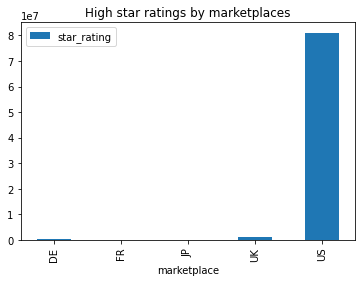

In [19]:
%matplotlib inline
phs_df.plot(kind="bar")
plt.title('High star ratings by marketplaces');

This captures the distribution of high ratings (larger than 3) across countries. It can be seen that the US contributes the most high ratings, which could serve as a predictor of high ratings.

----

In [21]:
place_help_total = (df[['total_votes', 'marketplace','helpful_votes']].groupby('marketplace')
                                                       .sum())
pht_df = place_help_total.compute()
pht_df

,total_votes,helpful_votes
marketplace,,
DE,232938,150758
FR,84698,59786
JP,102132,76599
UK,1107245,768853
US,108987911,78459393


In [22]:
pht_df['ratio']=pht_df['helpful_votes']/pht_df['total_votes']

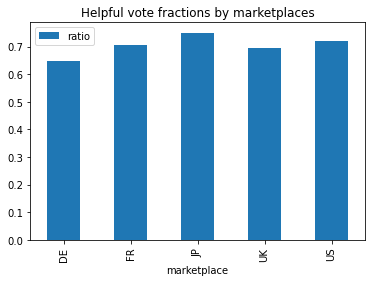

In [23]:
pht_df[['ratio']].plot(kind="bar")
plt.title('Helpful vote fractions by marketplaces');

This shows how the ratios of helpful votes in all votes are distributed across countries. As shown in the figure, these ratios are mostly similar, but Japan has the highest helpful-total ratio, indicating that using the ratio of helpful votes as a predictor should not be affected/interacted by the countries.

----

In [25]:
noveri = (df[['marketplace','verified_purchase']].loc[df['verified_purchase']=='N']
                                                           .groupby('marketplace')                                                        
                                                              .count())
nv_df = noveri.compute()

place_purch = (df[['marketplace','verified_purchase']].loc[df['verified_purchase']=='Y']
                                                           .groupby('marketplace')
                                                           .count())
pp_df = place_purch.compute()

In [26]:
pp_df['not_verified']=nv_df['verified_purchase']
pp_df['ratio']=pp_df['verified_purchase']/(pp_df['not_verified']+pp_df['verified_purchase'])

In [27]:
pp_df

,verified_purchase,not_verified,ratio
marketplace,,,
DE,18291,45569,0.286423
FR,11866,9596,0.552884
JP,7648,5003,0.604537
UK,155125,102932,0.601127
US,10397122,9973008,0.510410


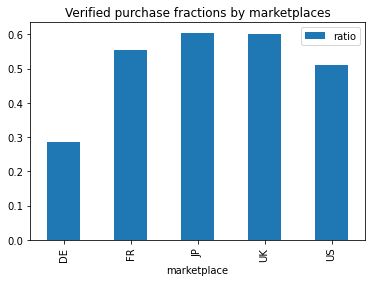

In [33]:
pp_df[['ratio']].plot(kind="bar")
plt.title('Verified purchase fractions by marketplaces');

This shows how the percentages of verified purchases are distributed across countries. As shown in the figure, the percentage of verified purchase is extremely low in Germany, while similar in other countries, with the highest in Japan, indicating that whether a purchase is verified should be taken into consideration when predicting ratings, especially with the case of Germany.

-----

In [30]:
helpful_by_star = (df[['star_rating', 'helpful_votes']].loc[df['verified_purchase']=='Y']
                                                       .groupby('star_rating')
                                                       .sum())
helpful_df = helpful_by_star.compute()
helpful_df

,helpful_votes
star_rating,
1,2399727
2,1715575
3,2242362
4,3062628
5,13236604


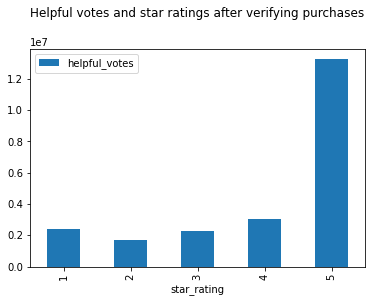

In [36]:
helpful_df.plot(kind="bar")
plt.title('Helpful votes and star ratings after verifying purchases',y=1.12);

This shows how star ratings are correlated with helpful votes after purchases have been verified. As shown in the figure, a high correlation between 5-star rating and helpful votes can be conlucded, potentially predicting high ratings like 5 star.

----

In [38]:
star_loc = (df[['star_rating', 'marketplace','verified_purchase']].loc[df['verified_purchase']=='Y']
                                            .loc[df['star_rating']>3]
                                            .groupby('marketplace')
                                            .sum())
sl_df = star_loc.compute()


all_star_loc = (df[['star_rating', 'marketplace','verified_purchase']].loc[df['verified_purchase']=='Y']
                                                  .groupby('marketplace')
                                                  .sum())
asl_df = all_star_loc.compute()

In [39]:
sl_df['all_rating']=asl_df['star_rating']
sl_df['ratio']=sl_df['star_rating']/(sl_df['all_rating']+sl_df['star_rating'])

In [40]:
sl_df

,star_rating,all_rating,ratio
marketplace,,,
DE,75691,81493,0.481544
FR,46896,51678,0.475744
JP,31293,33819,0.480603
UK,654071,698893,0.483436
US,43067054,46317935,0.481815


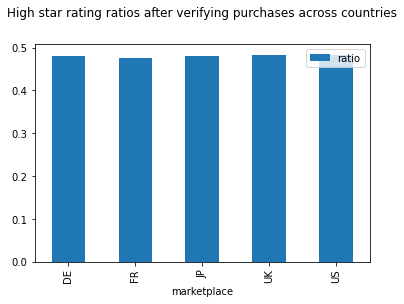

In [43]:
sl_df[['ratio']].plot(kind="bar")
plt.title('High star rating ratios after verifying purchases across countries', y=1.1);

This shows the ratios of high ratings in all star ratings across countries. As shown in figure, the ratios are approximately similar, indicating countries may not be a good predictor for the ratios.

----

In [44]:
cluster.shutdown()

distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://172.31.85.14:44969', name: dask.worker_0, status: running, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://172.31.85.14:44969
